## TF-IDF + Log Reg
### Training Pipeline

In [1]:
# !pip install dagshub

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import dagshub
import pickle

In [16]:
def load_corpus(DATASET_PATH, CODE_COLUMN):
    df = pd.read_csv(DATASET_PATH, encoding='utf-8', comment='#', sep=',')#, quoting=csv.QUOTE_NONE, error_bad_lines=False)#, sep=','
    print(df.head())
    corpus = df[CODE_COLUMN]
    test_size = 0.1
    test_rows = round(df.shape[0]*test_size)
    train_rows = df.shape[0] - test_rows
    train_corpus = df[CODE_COLUMN][0:test_rows]
    test_corpus = df[CODE_COLUMN][train_rows:]
    return df, corpus

In [17]:
def tfidf_transform(corpus, tfidf_params, TFIDF_DIR):
#     tfidf = TfidfVectorizer(min_df=5
#                             , max_df = 0.3
#                             , ngram_range = (1,2)
#                             , smooth_idf = True
#                            )
    # tfidf = TfidfVectorizer(tfidf_params)
    # features = tfidf.fit_transform(corpus)
    tfidf = pickle.load(open(TFIDF_DIR, 'rb'))
    features = tfidf.transform(corpus)
    return features

In [18]:
def tfidf_fit_transform(code_blocks, tfidf_params, TFIDF_DIR):
    tfidf = TfidfVectorizer(tfidf_params)
    tfidf = tfidf.fit(code_blocks)
    pickle.dump(tfidf, open(TFIDF_DIR, "wb"))
    code_blocks_tfidf = tfidf.transform(code_blocks)
    return code_blocks_tfidf

In [19]:
def logreg_evaluate(df, code_blocks, TAG_TO_PREDICT):
    code_blocks_tfidf = tfidf_fit_transform(code_blocks, tfidf_params, TFIDF_DIR)
    X_train, X_test, y_train, y_test = train_test_split(code_blocks_tfidf, df[TAG_TO_PREDICT], test_size=0.25)
    clf = LogisticRegression(random_state=421).fit(X_train, y_train)
    # clf.fit(X_train, y_train)
    print("saving the model")
    pickle.dump(clf, open(MODEL_DIR, 'wb'))
    y_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    f1 = f1_score(y_pred, y_test)
    print(f'Mean Accuracy {round(accuracy*100, 2)}%')
    print(f'F1-score {round(f1*100, 2)}%')
    errors = y_test - y_pred
    plt.hist(errors)
    plot_precision_recall_curve(clf, X_test, y_test)
    plot_confusion_matrix(clf, X_test, y_test, values_format='d')
    def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h
    conf_interval = mean_confidence_interval(errors, 0.95)
    print(conf_interval)
    metrics = {'test_accuracy': accuracy
               , 'test_f1_score': f1}
    return metrics

In [20]:
def get_predictions(X, y, TAG_TO_PREDICT, MODEL_DIR):
    clf = pickle.load(open(MODEL_DIR, 'rb'))
    # result = loaded_model.score(X, y)
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y_pred, y)
    f1 = f1_score(y_pred, y, average='weighted')
    print(f'Mean Accuracy {round(accuracy*100, 2)}%')
    print(f'F1-score {round(f1*100, 2)}%')
    errors = y - y_pred
    plt.hist(errors)
    plot_precision_recall_curve(clf, X, y)
    plot_confusion_matrix(clf, X, y, values_format='d')
    def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h
    conf_interval = mean_confidence_interval(errors, 0.95)
    print(conf_interval)
    metrics = {'test_accuracy': accuracy
               , 'test_f1_score': f1}
    return metrics

### Evaluation

index  Unnamed: 0                                         code_block  \
0      0           0  \r\nimport pandas as pd\r\nimport matplotlib.p...   
1      1           1  \r\ndf_train = pd.read_csv('../input/train.csv'),   
2      2           2                              \r\ndf_train.columns,   
3      3           3              \r\ndf_train['SalePrice'].describe(),   
4      4           4          \r\nsns.distplot(df_train['SalePrice']);,   

                                      tag  preprocessing  visualization  \
0  ['invite people for the kaggle party']              1              1   
1              ['bring in the six packs']              0              0   
2                ['check the decoration']              0              0   
3      ['descriptive statistics summary']              0              0   
4                           ['histogram']              0              1   

   model  train  predict  
0      0      0        0  
1      0      0        0  
2      0      0     

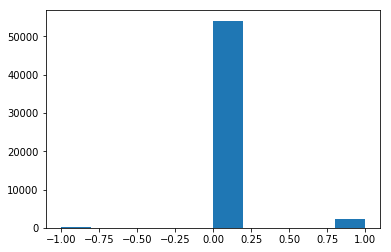

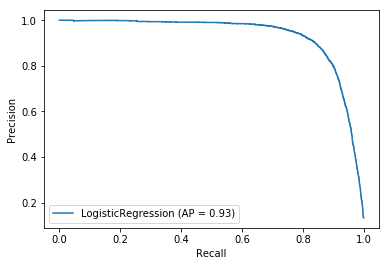

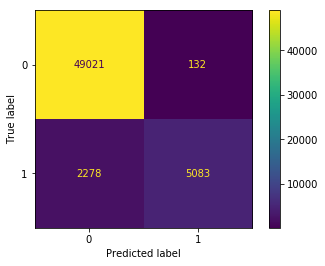

In [21]:
if __name__ == '__main__':
    DATASET_PATH = './data/code_blocks_regex_graph_v2.1.csv'
    MODEL_DIR = './models/logreg_regex_graph_v2.1.sav'
    TFIDF_DIR = './models/tfidf_logreg_graph_v2.1.pickle'
    CODE_COLUMN = 'code_block'
    TAG_TO_PREDICT = 'preprocessing'
    SCRIPT_DIR = 'logreg_classifier.ipynb'

    df, code_blocks = load_corpus(DATASET_PATH, CODE_COLUMN)
    nrows = df.shape[0]
    print("loaded")
    tfidf_params = {'min_df': 5
                    , 'max_df': 0.3
                    , 'smooth_idf': True}
    data_meta = {'DATASET_PATH': DATASET_PATH
                ,'nrows': nrows
                ,'label': TAG_TO_PREDICT
                ,'model': MODEL_DIR
                ,'script_dir': SCRIPT_DIR}
    print("tfidf-ed")
    with dagshub.dagshub_logger() as logger:
        metrics = logreg_evaluate(df, code_blocks, TAG_TO_PREDICT)
        # metrics = get_predictions(features, df[TAG_TO_PREDICT], TAG_TO_PREDICT, MODEL_DIR)
        logger.log_hyperparams(data_meta)
        logger.log_hyperparams(tfidf_params)
        logger.log_metrics(metrics)
    print("finished")

### Validation (different chunk_sizes)

In [9]:
# if __name__ == '__main__':
#     all_metrics = []
#     chunk_sizes = [5, 10, 15, 20, 25, 30, 40]
#     for i in chunk_sizes:
#         DATASET_PATH = './data/chunks_{}_validate.csv'.format(i)
#         MODEL_DIR = './models/logreg_regex_graph_v2.sav'
#         TFIDF_DIR = './models/tfidf_logreg_graph_v2.pickle'
#         CODE_COLUMN = 'code'
#         TAG_TO_PREDICT = 'tag'
#         df, corpus = load_corpus(DATASET_PATH, CODE_COLUMN)
#         nrows = df.shape[0]
#         print("loaded")
#         params = {'min_df': 5
#                 , 'max_df': 0.3
#                 , 'smooth_idf': True}
#         data_meta = {'DATASET_PATH': DATASET_PATH
#                     ,'nrows': nrows
#                     ,'label': TAG_TO_PREDICT
#                     ,'model': 'Logistic Regression'}
#         features = tfidf_transform(corpus, params, TFIDF_DIR)
#         print("tfidf-ed")
#         with dagshub.dagshub_logger() as logger:
#             # metrics = logreg_evaluate(df, features, TAG_TO_PREDICT)
#             metrics = get_predictions(features, df[TAG_TO_PREDICT], TAG_TO_PREDICT, MODEL_DIR)
#             all_metrics.append(metrics)
#             logger.log_hyperparams(data_meta)
#             logger.log_hyperparams(params)
#             logger.log_metrics(metrics)
#         print("finished")

In [10]:
# all_acc = [all_metrics[i]['test_accuracy'] for i in range(len(all_metrics))]
# all_f1 = [all_metrics[i]['test_f1_score'] for i in range(len(all_metrics))]
# plt.scatter(chunk_sizes, all_acc)
# plt.scatter(chunk_sizes, all_f1)

## Log Reg Interpretation

In [11]:
# def analyze_predictions(X, y, TAG_TO_PREDICT, MODEL_DIR):
#     clf = pickle.load(open(MODEL_DIR, 'rb'))
#     # result = loaded_model.score(X, y)
#     y_pred = clf.predict(X)
#     accuracy = accuracy_score(y_pred, y)
#     f1 = f1_score(y_pred, y, average='weighted')
#     print(f'Mean Accuracy {round(accuracy*100, 2)}%')
#     print(f'F1-score {round(f1*100, 2)}%')
#     errors = y - y_pred
#     plt.hist(errors)
#     plot_precision_recall_curve(clf, X, y)
#     plot_confusion_matrix(clf, X, y, values_format='d')
#     def mean_confidence_interval(data, confidence=0.95):
#         a = 1.0 * np.array(data)
#         n = len(a)
#         m, se = np.mean(a), scipy.stats.sem(a)
#         h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#         return m, m-h, m+h
#     conf_interval = mean_confidence_interval(errors, 0.95)
#     print(conf_interval)
#     metrics = {'test_accuracy': accuracy
#                , 'test_f1_score': f1}
#     return X, y, y_pred
# if __name__ == '__main__':
#     DATASET_PATH = './data/chunks_10_validate.csv'
#     MODEL_DIR = './models/logreg_regex_graph_v2.sav'
#     TFIDF_DIR = './models/tfidf_logreg_graph_v2.pickle'
#     CODE_COLUMN = 'code'
#     TAG_TO_PREDICT = 'tag'
#     df, corpus = load_corpus(DATASET_PATH, CODE_COLUMN)
#     nrows = df.shape[0]
#     print("loaded")
#     params = {'min_df': 5
#              , 'max_df': 0.3
#              , 'smooth_idf': True}
#     data_meta = {'DATASET_PATH': DATASET_PATH
#                 ,'nrows': nrows
#                 ,'label': TAG_TO_PREDICT
#                 ,'model': 'Logistic Regression'}
#     features = tfidf_transform(corpus, params, TFIDF_DIR)
#     print("tfidf-ed")
#     X, y, y_pred = analyze_predictions(features, df[TAG_TO_PREDICT], TAG_TO_PREDICT, MODEL_DIR)
#     print("finished")

In [12]:
# pd.set_option('max_colwidth', 500)
# pd.set_option('max_rows', 500)

In [13]:
# ## False Positives (preprocessing y/n)
# corpus[(y_pred-y)==-1].reset_index(drop=True)[:]

In [14]:
# show_most_informative_features(model=pickle.load(open(MODEL_DIR, 'rb')),
#                                 vectorizer=pickle.load(open(TFIDF_DIR, 'rb')),
#                                 text=corpus[5])